# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of SBVS, molecular descriptors and machine learning techniques for identifying active and inactive compounds given an SARS-CoV-2 assay. [PostEra.ai](https://covid.postera.ai/covid/activity_data)'s bioassay is the main set, which RapidFire and fluorescence data are used for dividing and labeling the train and test sets' compounds into active and inactive. The constructed models are then assessed as to their ability to classify active and inactive coumpounds given a number of descriptors.

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

1. [Reading data](#reading_data)
2. [Machine learning](#machine_learning)    
    a. [Evaluation metrics](#evaluation_metrics)    
    b. [Constructing the models](#constructing_models)    
3. [Performace analysis](#performance_analysis)     
    a. [Comparing different models and rescaling methods](#comparing)    
    b. [Finding the best subset](#finding)     
    c. [ROC curves](#roc_curves)

<a id='reading_data'></a>
## Reading data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)
top_qvina.head()

,CID,qvina,rfscore_qvina
0,MAR-UNI-c84db004-13,-9.0,6.586498
1,BAR-COM-4e090d3a-53,-7.5,7.221692
2,TRY-UNI-714a760b-6,-6.4,6.377253
3,EDJ-MED-c9f55a56-1,-6.2,5.491030
4,LON-WEI-0a73fcb8-7,-7.4,6.677942


In [3]:
# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)
top_plants.head()

,CID,plants,rfscore_plants
0,EDG-MED-0da5ad92-3,-70.8540,6.885798
1,DAR-DIA-23aa0b97-19,-79.4982,6.852397
2,MAT-POS-590ac91e-22,-70.4662,6.217164
3,LON-WEI-1908424e-3,-90.5268,7.534084
4,GIA-UNK-30c7cb75-1,-76.6202,6.839672


In [4]:
# Read experimental data
experimental = pd.read_csv('activity_data.csv')
experimental.head()

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series
0,COC(=O)C(C(=O)Nc1cnccc1C)c1cccc(Cl)c1,MAT-POS-1e5f28a7-1,MAT-POS-1e5f28a7-1,NaN,NaN,17.091397,NaN,NaN,23.712295,4.625026,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like
1,OCCn1c(CSc2nc3ccccc3o2)nc2ccc(Cl)cc21,MAT-POS-e10a589d-1,MAT-POS-e10a589d-1,NaN,NaN,99.000000,NaN,NaN,0.326703,6.485847,NaN,NaN,NaN,NaN,False,False,NaN
2,N#Cc1ncn(CC(=O)Nc2ccc(Br)cc2Cl)n1,MAT-POS-e10a589d-4,MAT-POS-e10a589d-4,NaN,NaN,NaN,NaN,NaN,15.730897,4.803247,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like
3,Cn1nc(-c2ccc(C(F)(F)F)cc2)nc2c(=O)n(C)c(=O)nc1-2,MAT-POS-1e0c1c67-1,MAT-POS-1e0c1c67-1,NaN,NaN,99.000000,NaN,NaN,2.400602,5.619680,NaN,NaN,NaN,NaN,False,False,NaN
4,Cc1cc2c(cc1C)C(C(=O)N1CCCCC1c1cn[nH]c1)CO2,MAT-POS-6da3605a-1,MAT-POS-6da3605a-1,NaN,NaN,99.000000,NaN,NaN,99.500000,NaN,NaN,NaN,NaN,NaN,False,False,NaN


,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.00000,0.69973
f_inhibition_at_50_uM,0.69973,1.00000


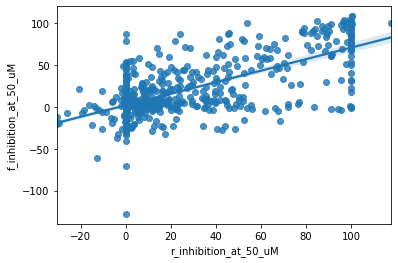

In [5]:
# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(experimental['r_inhibition_at_50_uM'], experimental['f_inhibition_at_50_uM'])
experimental[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

In [6]:
# Merge top scores and experimental data
tmp = pd.merge(top_qvina, top_plants)
top = pd.merge(tmp, experimental[['CID','r_inhibition_at_50_uM','r_avg_IC50','f_inhibition_at_50_uM','f_avg_IC50']])
del tmp

# Normalize scores
top['plants'] /= 10
top[['rfscore_qvina','rfscore_plants']] *= -1

top

,CID,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_50_uM,f_avg_IC50
0,MAR-UNI-c84db004-13,-9.0,-6.586498,-8.59230,-7.447876,0.000000,NaN,NaN,NaN
1,BAR-COM-4e090d3a-53,-7.5,-7.221692,-8.38857,-7.340981,0.000000,NaN,16.960570,NaN
2,TRY-UNI-714a760b-6,-6.4,-6.377253,-6.87197,-6.414523,NaN,13.895165,81.756960,24.566619
3,EDJ-MED-c9f55a56-1,-6.2,-5.491030,-6.94555,-6.042434,4.870901,NaN,0.403773,NaN
4,LON-WEI-0a73fcb8-7,-7.4,-6.677942,-7.34504,-6.826287,58.930356,66.350807,84.229060,13.671987
...,...,...,...,...,...,...,...,...,...
938,MED-COV-4280ac29-14,-6.5,-6.078443,-6.41177,-6.060790,0.000000,NaN,5.547850,NaN
939,DAR-DIA-842b4336-13,-5.9,-6.208389,-7.20692,-6.147168,NaN,NaN,11.500410,NaN
940,MAK-UNK-d4768348-1,-6.1,-7.048776,-6.85433,-7.249597,NaN,0.484415,73.746190,1.630843
941,CHR-SOS-7098f804-3,-6.9,-6.042820,-7.66604,-6.431856,5.996569,NaN,-15.617840,NaN


In [7]:
# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Merge descriptors to "top"
data = pd.merge(top, descriptors)
data.rename({'VABC Volume Descriptor': 'Volume', 'Rotatable Bonds Count': 'Rotatable Bonds', 'Topological Polar Surface Area': 'TPSA'}, axis=1, inplace=True)

# Label actives and inactives
data.dropna(subset=['r_inhibition_at_50_uM'], inplace=True)
data['Active'] = data['r_inhibition_at_50_uM'] > 50
data['Active'] = data['Active'].astype(int) # 1 for active, 0 for inactive

data.head()

,CID,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_50_uM,f_avg_IC50,Volume,Rotatable Bonds,TPSA,Molecular Weight,XLogP,Active
0,MAR-UNI-c84db004-13,-9.0,-6.586498,-8.59230,-7.447876,0.000000,NaN,NaN,NaN,424.84863706529114,6,111.52,510.131468,5.100,0
1,BAR-COM-4e090d3a-53,-7.5,-7.221692,-8.38857,-7.340981,0.000000,NaN,16.960570,NaN,275.6888879402175,6,93.21,312.122240,-0.187,0
3,EDJ-MED-c9f55a56-1,-6.2,-5.491030,-6.94555,-6.042434,4.870901,NaN,0.403773,NaN,206.5538721380282,5,70.67,230.116761,1.169,0
4,LON-WEI-0a73fcb8-7,-7.4,-6.677942,-7.34504,-6.826287,58.930356,66.350807,84.229060,13.671987,271.54289399511737,5,71.45,318.077120,1.647,1
5,MAT-POS-590ac91e-3,-5.6,-5.398376,-6.23559,-5.965573,0.000000,NaN,-2.197802,NaN,197.1670371230559,3,51.22,218.105528,-0.292,0


<a id='machine_learning'></a>
## Machine learning

In [8]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBRegressor

In [10]:
import multiprocessing
from functools import partial
import itertools
import time

<a id='evaluation_metrics'></a>
### Evaluation metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [11]:
scoring_metrics = ['accuracy','f1','precision','recall','roc_auc']

<a id='constructing_models'></a>
### Constructing the models

In [12]:
# Rebalance data with SMOTE and cross validate model
def get_mean_scores(data, subset, model, scaler=None):
    new_data = data.dropna(subset=subset)
    y = new_data['Active']
    X = new_data[subset].values
    
    if scaler is not None:
        # Scale data to [0, 1]
        scaler.fit_transform(X)
    
    pipe = make_pipeline(SMOTE(random_state=42), model)

    mean_scores = [np.mean(i) for i in cross_validate(pipe, X, y, scoring=scoring_metrics).values()]
    mean_scores.append(str(model).split('(')[0])
    mean_scores.append(str(scaler).split('(')[0])
    mean_scores.append(subset)
    
    return mean_scores

In [13]:
xgb_scores = get_mean_scores(data, subset=['qvina','Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP'], 
                             model=XGBRegressor(objective='reg:squarederror', random_state=13))
pd.DataFrame(xgb_scores, columns=['fit_time','score_time','test_accuracy','test_f1','test_precision',
         'test_recall','test_roc_auc','model','scaler','subset'])

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [14]:
def run_models(data, subset, columns):
    # DataFrame for all models' scores
    scores_data = pd.DataFrame()

    # Loop through all subset combinations (2, N)
    for s in itertools.chain.from_iterable(itertools.combinations(subset, r) for r in range(2, len(subset)+1)):
        s = list(s)
        scalers_list = [None, RobustScaler(), MinMaxScaler(), StandardScaler()]
        model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                     RandomForestClassifier(n_estimators=10, random_state=13), 
                     KNeighborsClassifier(n_neighbors=3), 
                     LinearSVC(dual=False, random_state=13)]#,
                     #XGBRegressor(objective='reg:squarederror', random_state=13)]

        # Arguments for pool.map
        args = [(s, i[0], i[1]) for i in itertools.product(model_list, scalers_list)]

        # Define number of processes
        ncpu = multiprocessing.cpu_count()
        with multiprocessing.Pool(processes=ncpu-1) as pool:
            scores = pool.starmap(partial(get_mean_scores, data), args)

        # Append scores to all scores
        scores = pd.DataFrame(scores, columns=columns)
        scores_data = scores_data.append(scores)
    
    return scores_data

In [15]:
t0 = time.time()

# Descriptors
subset  = ['qvina','rfscore_qvina','plants','rfscore_plants',
          'Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP']

# Test metrics
columns = ['fit_time','score_time','test_accuracy','test_f1','test_precision',
         'test_recall','test_roc_auc','model','scaler','subset']

scores_data = run_models(data, subset, columns)
    
t1 = time.time()
print('{:g}m:{:g}s'.format(*divmod(t1 - t0, 60)))

11m:2.78497s


In [16]:
scores_data.drop(['fit_time','score_time'], axis=1, inplace=True)
scores_data.to_csv('scores_data.csv', index=False)

<a id='performance_analysis'></a>
## Performance analysis

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
from ast import literal_eval

In [19]:
# Read test scores and convert "subset" from type "str" to type "list" (we're going to need that later)
scores_data = pd.read_csv('scores_data.csv', converters={'subset': literal_eval})
scores_data.sort_values('test_roc_auc', ascending=False, inplace=True)
columns = scores_data.columns

In [20]:
scores_data.head()

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,model,scaler,subset
6675,0.717568,0.472317,0.364059,0.684392,0.761949,LogisticRegression,StandardScaler,"[qvina, plants, Volume, Rotatable Bonds, TPSA,..."
6672,0.717568,0.472317,0.364059,0.684392,0.761949,LogisticRegression,None,"[qvina, plants, Volume, Rotatable Bonds, TPSA,..."
6674,0.717568,0.472317,0.364059,0.684392,0.761949,LogisticRegression,MinMaxScaler,"[qvina, plants, Volume, Rotatable Bonds, TPSA,..."
6673,0.717568,0.472317,0.364059,0.684392,0.761949,LogisticRegression,RobustScaler,"[qvina, plants, Volume, Rotatable Bonds, TPSA,..."
6832,0.716216,0.465658,0.360026,0.669841,0.761498,LogisticRegression,None,"[qvina, Volume, Rotatable Bonds, TPSA, Molecul..."


<a id='comparing'></a>
### Comparing different models and rescaling methods

In [21]:
melt = pd.melt(scores_data, id_vars=columns[-3:], value_vars=columns[:5])

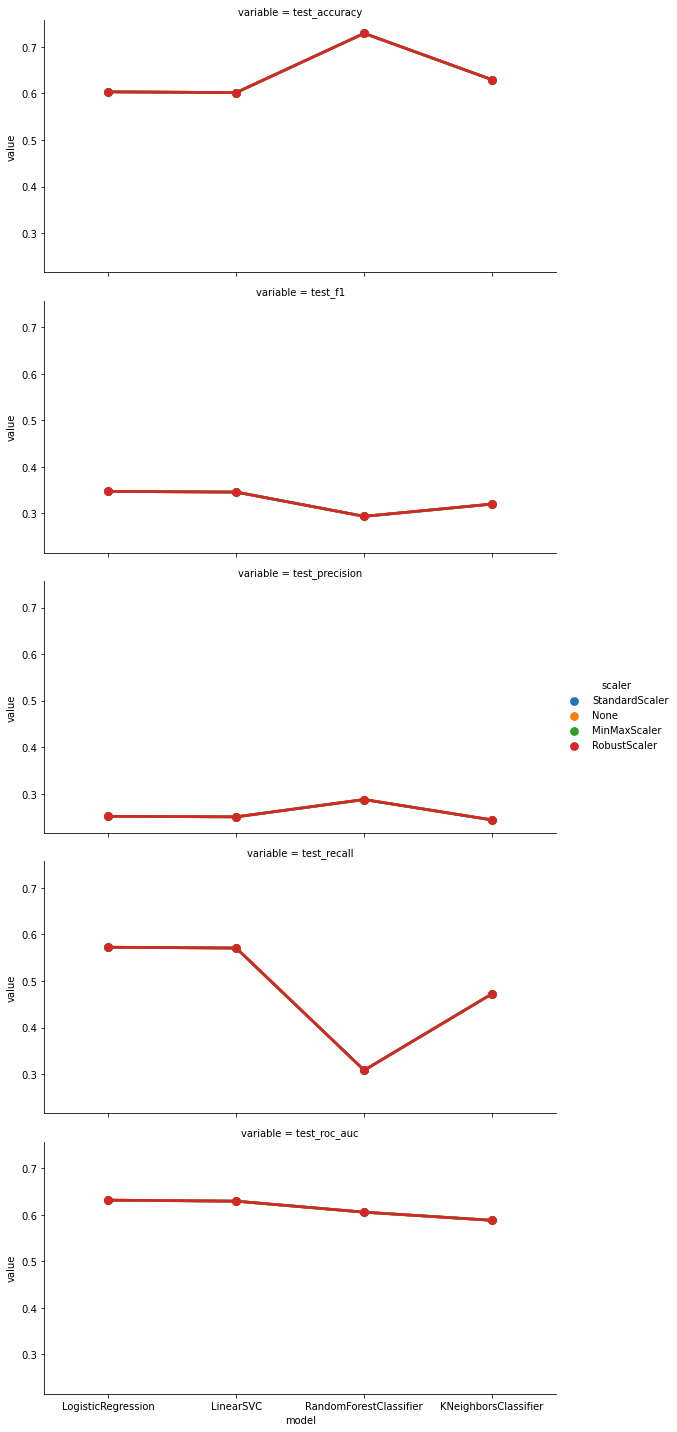

In [22]:
sns.catplot(kind='point', data=melt, x='model', y='value', hue='scaler', row='variable', height=4, aspect=2)

It is noticeable that rescaling the data didn't change the results. Thus, no rescaling will be applied to the final models.    
<a id='finding'></a>
### Finding the best subset

In [23]:
top_scores = scores_data.query('scaler == "None"')
top_scores.groupby('model').head(1)

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,model,scaler,subset
6672,0.717568,0.472317,0.364059,0.684392,0.761949,LogisticRegression,None,"[qvina, plants, Volume, Rotatable Bonds, TPSA,..."
6684,0.718919,0.470187,0.363318,0.677249,0.760438,LinearSVC,None,"[qvina, plants, Volume, Rotatable Bonds, TPSA,..."
4708,0.767568,0.396593,0.377324,0.418254,0.706553,RandomForestClassifier,None,"[qvina, plants, Volume, TPSA, Molecular Weight]"
3032,0.655405,0.371487,0.279188,0.558466,0.661877,KNeighborsClassifier,None,"[rfscore_qvina, plants, TPSA, XLogP]"


In [24]:
subset  = ['qvina','rfscore_qvina','plants','rfscore_plants',
          'Volume','Rotatable Bonds','TPSA','Molecular Weight','XLogP']
n_occurrences = dict.fromkeys(subset, 0)

# How frequently does each descriptor appear in the top 20 scores?
for i, row in top_scores.iloc[:20].iterrows():
    for descriptor in subset:
        n_occurrences[descriptor] += row['subset'].count(descriptor)

n_occurrences

{'qvina': 20,
 'rfscore_qvina': 9,
 'plants': 12,
 'rfscore_plants': 6,
 'Volume': 20,
 'Rotatable Bonds': 20,
 'TPSA': 20,
 'Molecular Weight': 20,
 'XLogP': 11}

The frequency count shows "qvina", "Volume", "Rotatable bonds", "TPSA" and "Molecular Weight" are the most recurring descriptors.     
So let us construct and cross validate Logistic Regression, Linear SVC, RF and KNN models with these descriptors, then plot their ROC curves.     
<a id='roc_curves'></a>
### ROC curves

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

In [26]:
from sklearn.calibration import CalibratedClassifierCV

In [57]:
subset = ['qvina','Volume','Rotatable Bonds','TPSA','Molecular Weight']
new_data = data.dropna(subset=subset)
y = new_data['Active']
X = new_data[subset].values

model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                    CalibratedClassifierCV(LinearSVC(dual=False, random_state=13)), 
                    RandomForestClassifier(n_estimators=10, random_state=13), 
                    KNeighborsClassifier(n_neighbors=3)]
                    # LinearSVC doesn't have a "predict_proba" function, but sklearn provides 
                    # "CalibratedClassifierCV" for this purpose

for model in model_list:
    pipe = make_pipeline(SMOTE(random_state=42), model)
    y_proba = cross_val_predict(pipe, X, y, method='predict_proba')
    model_name = str(model)
    if 'LinearSVC' in model_name:
        model_name = 'LinearSVC'
    else:
        model_name = model_name.split('(')[0]
    data[model_name] = y_proba[:,1]

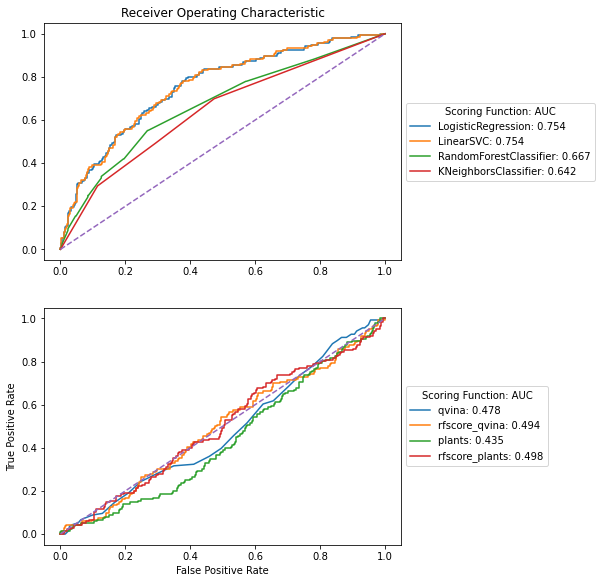

In [60]:
fig, ax = plt.subplots(nrows=2, figsize=(6.4, 9.6))
for model in ['LogisticRegression','LinearSVC','RandomForestClassifier','KNeighborsClassifier']:
    fpr, tpr,_ = roc_curve(data['Active'].values, data[model].values)
    ax[0].plot(fpr, tpr, label=f'{model}: {auc(fpr, tpr):>.3f}')

# Plot a line
ax[0].plot([0,1], [0,1], linestyle='--')

# Some legends
ax[0].set_title('Receiver Operating Characteristic')
ax[0].legend(title='Scoring Function: AUC', loc='center left', bbox_to_anchor=(1.0, 0.5))

for SF in ['qvina','rfscore_qvina','plants','rfscore_plants']:
    fpr, tpr, _ = roc_curve(data['Active'].values, data[SF].values)
    ax[1].plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')

# Plot a line
ax[1].plot([0,1], [0,1], linestyle='--')

# Some legends
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax[1].legend(title='Scoring Function: AUC', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('roc_auc.png')

We can see that Logistic Regression and Linear SVC were the best models and that they yielded very similar results.         
Considering Logistic Regression is the most frequent one in the top scores, we can assume it is the most adequate model for our problem.

In [104]:
melt = pd.melt(data, id_vars=['CID'], value_vars=['qvina','rfscore_qvina','plants','rfscore_plants',
                                          'LogisticRegression','LinearSVC','RandomForestClassifier','KNeighborsClassifier'])
df_tidy = pd.merge(data[['CID','r_inhibition_at_50_uM']], melt, on=['CID'])

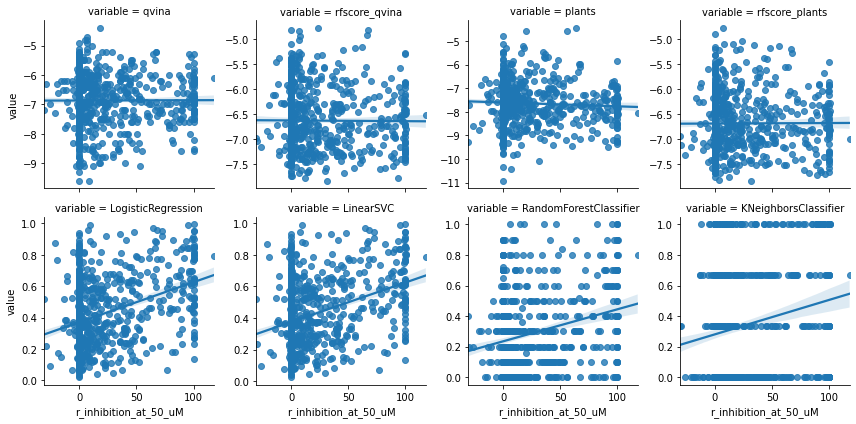

In [107]:
g = sns.FacetGrid(data=df_tidy, col='variable', col_wrap=4, sharey=False)
g.map(sns.regplot, 'r_inhibition_at_50_uM', 'value')